In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl
import rowan
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy import integrate
import pytransform3d.camera as pc
import pytransform3d.transformations as pt
import pytransform3d.rotations as pr
from utils import calc_quat_angle_error, integrate_angular_velocity, calc_rel_orientation

## Prepare COLMAP, IMU and Frame files

In [2]:
# aligned_colmap_image_file = 'C:/Users/tansi/Documents/Imperial_College_London/Year3/FYP_Project/aligned_campus_v2/images.txt'
# imu_data_file = './2022-06-16T17-06-18/MotARH.txt'
# frames_data_file = './2022-06-16T17-06-18/Frames.txt'

aligned_colmap_image_file = 'C:/Users/tansi/Documents/Imperial_College_London/Year3/FYP_Project/aligned_campus_v2_test/images.txt'
imu_data_file = './2022-06-16T17-07-10/MotARH.txt'
frames_data_file = './2022-06-16T17-07-10/Frames.txt'

In [3]:
frames_df = pd.read_csv(frames_data_file, sep = ",",header=None)
frames_df.columns = ['time','frameNumber','focalLenghtX','focalLenghtY','principalPointX','principalPointY']
frames_df.head()

,time,frameNumber,focalLenghtX,focalLenghtY,principalPointX,principalPointY
0,1.655396e+09,0,1606.102417,1606.102417,952.858826,681.516602
1,1.655396e+09,1,1606.102417,1606.102417,952.643188,681.551147
2,1.655396e+09,2,1606.102417,1606.102417,952.808899,681.566895
3,1.655396e+09,3,1606.102417,1606.102417,952.682739,681.606201
4,1.655396e+09,4,1606.102417,1606.102417,952.771545,681.491943


In [4]:
imu_df = pd.read_csv(imu_data_file, sep = ",",header=None)
imu_df.columns = ['time','ang_vel_x','ang_vel_y','ang_vel_z',
                 'gravity_x','gravity_y','gravity_z',
                 'imu_acc_x','imu_acc_y','imu_acc_z', 'motionHeading']
imu_df.head()

,time,ang_vel_x,ang_vel_y,ang_vel_z,gravity_x,gravity_y,gravity_z,imu_acc_x,imu_acc_y,imu_acc_z,motionHeading
0,1.655396e+09,-0.005453,-0.032914,-0.006149,-0.992980,-0.005169,-0.118168,0.000091,0.001400,0.005741,116.090034
1,1.655396e+09,-0.012828,-0.041183,-0.002344,-0.993026,-0.005203,-0.117778,-0.000290,0.003205,-0.003896,116.097343
2,1.655396e+09,-0.016968,-0.044446,-0.003149,-0.993071,-0.005210,-0.117401,-0.001329,0.000525,-0.007080,116.106125
3,1.655396e+09,-0.022272,-0.043901,-0.004282,-0.993120,-0.005212,-0.116989,-0.000212,-0.001730,-0.000305,116.118446
4,1.655396e+09,-0.021127,-0.036371,-0.002446,-0.993165,-0.005230,-0.116606,-0.000259,0.001629,0.001707,116.131905


In [5]:
frames_df["imu_acc_x"] = np.interp(frames_df["time"], imu_df["time"], imu_df["imu_acc_x"])
frames_df["imu_acc_y"] = np.interp(frames_df["time"], imu_df["time"], imu_df["imu_acc_y"])
frames_df["imu_acc_z"] = np.interp(frames_df["time"], imu_df["time"], imu_df["imu_acc_z"])
frames_df["ang_vel_x"] = np.interp(frames_df["time"], imu_df["time"], imu_df["ang_vel_x"])
frames_df["ang_vel_y"] = np.interp(frames_df["time"], imu_df["time"], imu_df["ang_vel_y"])
frames_df["ang_vel_z"] = np.interp(frames_df["time"], imu_df["time"], imu_df["ang_vel_z"])

<AxesSubplot:>

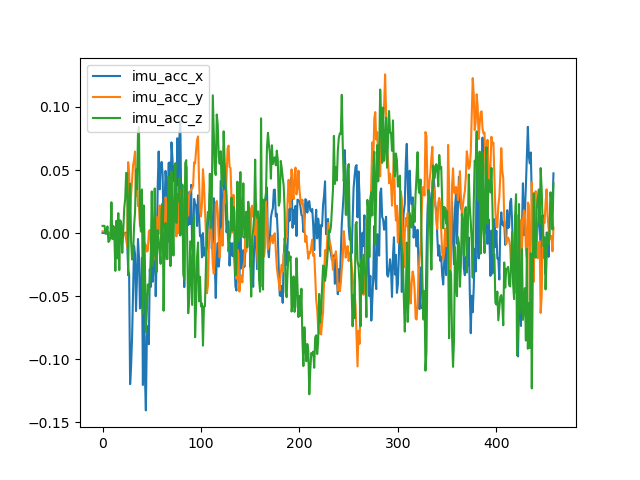

In [6]:
frames_df[["imu_acc_x", "imu_acc_y", "imu_acc_z"]].plot()

In [7]:
frames_df["seconds"] = frames_df["time"] - frames_df["time"][0]
frames_df["timestep"] = frames_df["time"] - frames_df["time"].shift(1)
frames_df["lin_vel_x"] = integrate.cumtrapz(frames_df["imu_acc_x"], frames_df["time"], initial=0)
frames_df["lin_vel_y"] = integrate.cumtrapz(frames_df["imu_acc_y"], frames_df["time"], initial=0)
frames_df["lin_vel_z"] = integrate.cumtrapz(frames_df["imu_acc_z"], frames_df["time"], initial=0)
frames_df["prev_lin_vel_x"] = frames_df["lin_vel_x"].shift(1)
frames_df["prev_lin_vel_y"] = frames_df["lin_vel_y"].shift(1)
frames_df["prev_lin_vel_z"] = frames_df["lin_vel_z"].shift(1)
frames_df["prev_imu_acc_x"] = frames_df["imu_acc_x"].shift(1)
frames_df["prev_imu_acc_y"] = frames_df["imu_acc_y"].shift(1)
frames_df["prev_imu_acc_z"] = frames_df["imu_acc_z"].shift(1)

In [8]:
camera_poses = pd.DataFrame()

with open(aligned_colmap_image_file, "r") as f:
    for line in f.readlines()[4::2]:
        values = line.strip('\n').split(" ")
        name = values[-1]
        q_w, q_x, q_y, q_z = values[1:5]
        r = R.from_quat(np.hstack([float(q_x), float(q_y), float(q_z), float(q_w)]))
        inv_r = r.inv()
        t_x, t_y, t_z = values[5:8]
        t_x, t_y, t_z = float(t_x), float(t_y), float(t_z)
        x, y, z = -inv_r.apply(np.hstack([t_x, t_y, t_z]))
        q_x, q_y, q_z, q_w = inv_r.as_quat()
        camera_poses = pd.concat([camera_poses, 
                                  pd.DataFrame.from_records([{'ImageFile': name, 
                                                              'POS_X': x,
                                                              'POS_Y': y,
                                                              'POS_Z': z, 
                                                              'Q_W': q_w,
                                                              'Q_X': q_x,
                                                              'Q_Y': q_y,
                                                              'Q_Z': q_z}])], ignore_index=True)

<AxesSubplot:>

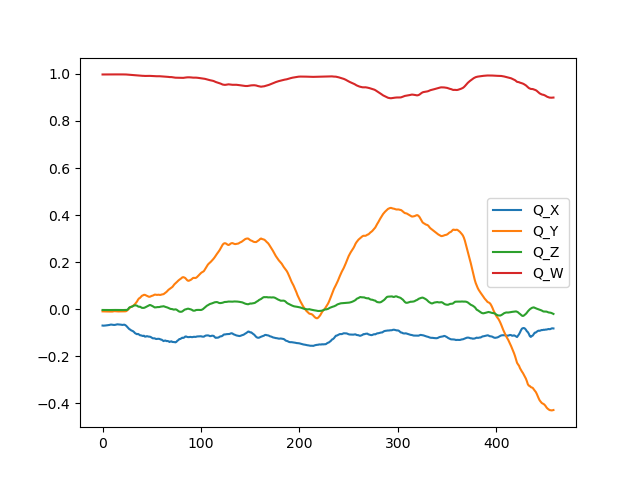

In [9]:
camera_poses["idx"] = camera_poses.apply(lambda row: int(row["ImageFile"].split(".")[0][6:]), axis = 1)
camera_poses.sort_values(by="idx", inplace= True)
camera_poses.reset_index(drop=True, inplace=True)
temp = pd.DataFrame()
temp["Q_X"] = -camera_poses["Q_W"]
temp["Q_Y"] = -camera_poses["Q_Z"]
temp["Q_Z"] = camera_poses["Q_Y"]
temp["Q_W"] = camera_poses["Q_X"]
camera_poses["Q_X"] = temp["Q_X"]
camera_poses["Q_Y"] = temp["Q_Y"]
camera_poses["Q_Z"] = temp["Q_Z"]
camera_poses["Q_W"] = temp["Q_W"]
camera_poses[["Q_X", "Q_Y", "Q_Z", "Q_W"]].plot()

In [10]:
noise_x = 0
noise_y = 0
noise_z = 0
# noise_x = np.random.normal(0,0.1,len(camera_poses))
# noise_y = np.random.normal(0,0.01,len(camera_poses))
# noise_z = np.random.normal(0,0.05,len(camera_poses))
camera_poses["noisy_POS_X"] = noise_x + camera_poses["POS_X"]
camera_poses["noisy_POS_Y"] = noise_y + camera_poses["POS_Y"]
camera_poses["noisy_POS_Z"] = noise_z + camera_poses["POS_Z"]


In [11]:
noise_qw = 0
noise_qx = 0
noise_qy = 0
noise_qz = 0

# noise_qw = np.random.normal(0,0.01,len(camera_poses))
# noise_qx = np.random.normal(0,0.01,len(camera_poses))
# noise_qy = np.random.normal(0,0.01,len(camera_poses))
# noise_qz = np.random.normal(0,0.01,len(camera_poses))
camera_poses["noisy_Q_W"] = noise_qw + camera_poses["Q_W"]
camera_poses["noisy_Q_X"] = noise_qx + camera_poses["Q_X"]
camera_poses["noisy_Q_Y"] = noise_qy + camera_poses["Q_Y"]
camera_poses["noisy_Q_Z"] = noise_qz + camera_poses["Q_Z"]

# Ensure that noisy quaternions is a valid rotation
normalized_q = pd.DataFrame(rowan.normalize(camera_poses[["noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z"]]), columns=["noisy_Q_W", "noisy_Q_X", "noisy_Q_Y", "noisy_Q_Z"])
camera_poses["noisy_Q_W"] = normalized_q["noisy_Q_W"]
camera_poses["noisy_Q_X"] = normalized_q["noisy_Q_X"]
camera_poses["noisy_Q_Y"] = normalized_q["noisy_Q_Y"]
camera_poses["noisy_Q_Z"] = normalized_q["noisy_Q_Z"]

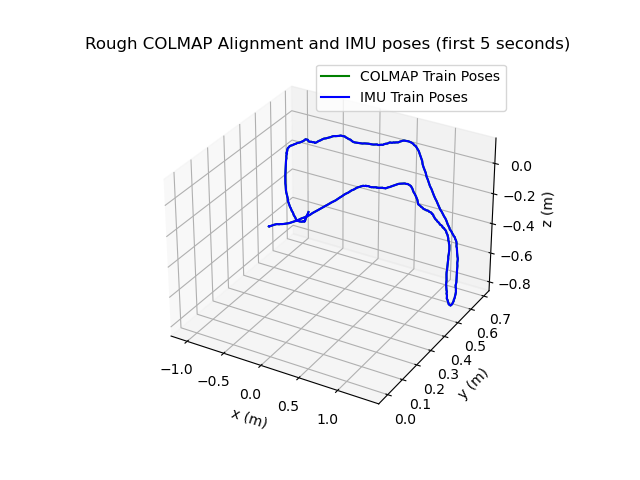

In [12]:
plt.figure()
ax = plt.axes(projection= '3d')
start = 0
end = -1
# x is left right, y is height, z is front back
ax.plot3D(camera_poses["POS_X"][start:end], camera_poses["POS_Y"][start:end], camera_poses["POS_Z"][start:end], label = "COLMAP Train Poses", color = 'green')
ax.plot3D(camera_poses["noisy_POS_X"][start:end], camera_poses["noisy_POS_Y"][start:end], camera_poses["noisy_POS_Z"][start:end], label = "IMU Train Poses", color = 'blue')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.set_title("Rough COLMAP Alignment and IMU poses (first 5 seconds)")
ax.legend()
plt.show()

In [13]:
frames_df = pd.concat([frames_df, camera_poses], axis = 1)

In [14]:
image_frame_step = 50
results = []
imu_idx = 1
for i in range(image_frame_step, len(frames_df), 1):
    row = frames_df.iloc[i,:]
    time = row.time
    x, y, z = row.POS_X, row.POS_Y, row.POS_Z
    print(f'prev {x,y,z}')
    time_taken = 0
    while frames_df.iloc[imu_idx,0] < time:
        imu_row = frames_df.iloc[imu_idx,:]
        x += imu_row.prev_lin_vel_x * imu_row.timestep + 1/2 * imu_row.prev_imu_acc_x * imu_row.timestep ** 2 
        y += imu_row.prev_lin_vel_y * imu_row.timestep + 1/2 * imu_row.prev_imu_acc_y * imu_row.timestep ** 2 
        z += imu_row.prev_lin_vel_z * imu_row.timestep + 1/2 * imu_row.prev_imu_acc_z * imu_row.timestep ** 2
        imu_idx += 1
        time_taken += imu_row.timestep
    print(f'imu added {x,y,z}, time taken {time_taken}')
    results.append([x, y, z])

imu_trans = pd.DataFrame(results, columns=["imu_POS_X", "imu_POS_Y","imu_POS_Z"])
imu_trans["idx"] = [i for i in range(image_frame_step, len(frames_df), 1)]
imu_trans.set_index("idx", inplace=True)

prev (0.12549934094460738, 0.16534859293494278, -0.07396232459646318)
imu added (0.10801132741339775, 0.17522466400459413, -0.06797358454787573), time taken 1.6331679821014404
prev (0.129612232357759, 0.18091845392671624, -0.07873340693676853)
imu added (0.12803833420540062, 0.1814374297901732, -0.0786566733923625), time taken 0.03332996368408203
prev (0.13351611510425282, 0.1967030247353695, -0.08276438811146236)
imu added (0.13193621757147866, 0.19720690013287925, -0.08265093787910179), time taken 0.03332996368408203
prev (0.13772323350322735, 0.21240987515140483, -0.08297284761026066)
imu added (0.13610052098485567, 0.21288864700130616, -0.08288820649406199), time taken 0.033329010009765625
prev (0.14141239404946832, 0.22852289556513006, -0.08627895341249767)
imu added (0.13976527129601526, 0.22899860333165512, -0.08621202428019076), time taken 0.03332996368408203
prev (0.1451358531750508, 0.24486989576851625, -0.08927980447421585)
imu added (0.14349375959412636, 0.2453225714574393,

<AxesSubplot:xlabel='idx'>

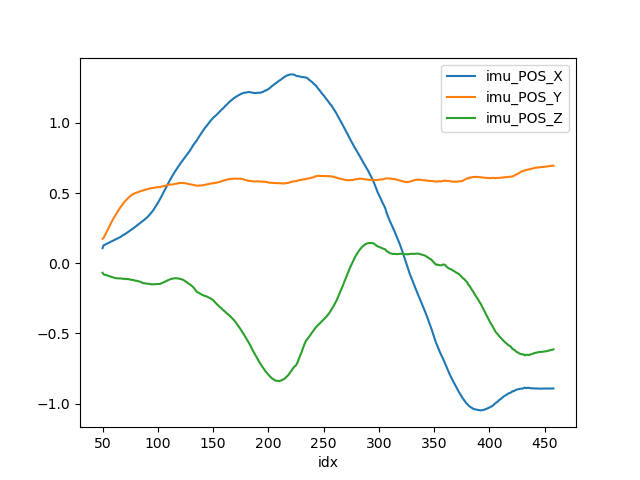

In [15]:
imu_trans[["imu_POS_X", "imu_POS_Y","imu_POS_Z"]].plot()

In [16]:
frames_df = pd.concat([frames_df, imu_trans], axis = 1)

In [17]:
frames_df['prev_ang_vel_x'] = frames_df['ang_vel_x'].shift(1) 
frames_df['prev_ang_vel_y'] = frames_df['ang_vel_y'].shift(1)
frames_df['prev_ang_vel_z'] = frames_df['ang_vel_z'].shift(1)

In [18]:
from ahrs.filters import AngularRate
results = []
imu_idx = 1
for i in range(image_frame_step, len(frames_df)):
    row = frames_df.iloc[i,:]
    time = row.time
    qw = row.Q_W
    qx = row.Q_X
    qy = row.Q_Y
    qz = row.Q_Z
    q_prev = np.array([qw, qx, qy, qz])
    print(f'prev {q_prev}')
    cur_q = q_prev
    angular_rate = AngularRate()
    while frames_df.iloc[imu_idx,0] < time:
        imu_row = frames_df.iloc[imu_idx,:]
        cur_q = angular_rate.update(cur_q, 
                                    np.hstack([imu_row["prev_ang_vel_x"],imu_row["prev_ang_vel_y"], imu_row["prev_ang_vel_z"]]),
                                    'closed', 
                                    1,
                                    imu_row['timestep'])
        cur_q = rowan.normalize(cur_q)
        imu_idx += 1
        time_taken += imu_row.timestep
    print(f'imu added {cur_q}, time taken {time_taken}')
    results.append(cur_q)

imu_q_ahrs = pd.DataFrame(results, columns=["imu_Q_W", "imu_Q_X", "imu_Q_Y", "imu_Q_Z"])
imu_q_ahrs["idx"] = [i for i in range(image_frame_step, len(frames_df), 1)]
imu_q_ahrs.set_index("idx", inplace=True)

prev [ 0.99093337 -0.12104111  0.05652794  0.01430737]
imu added [ 0.9926668  -0.05964385  0.10162456  0.02697562], time taken 1.6664979457855225
prev [ 0.99055187 -0.1238228   0.05761467  0.01246802]
imu added [ 0.99076777 -0.12163459  0.05904972  0.00986811], time taken 1.6998279094696045
prev [ 0.99041041 -0.1240392   0.05998035  0.01019058]
imu added [ 0.99038699 -0.1233985   0.06199712  0.0079235 ], time taken 1.7331578731536865
prev [ 0.99032454 -0.12401324  0.06183403  0.00738705]
imu added [ 0.99055119 -0.12207716  0.06231056  0.0047848 ], time taken 1.7664868831634521
prev [ 0.99003878 -0.12636562  0.06161293  0.00766726]
imu added [ 0.99049796 -0.12348629  0.06035472  0.00471509], time taken 1.7998168468475342
prev [ 0.99003362 -0.1267836   0.06076483  0.0081848 ]
imu added [ 0.99011605 -0.12566816  0.06195452  0.00627437], time taken 1.8331480026245117
prev [ 0.99010923 -0.1260723   0.06090374  0.00895663]
imu added [ 0.98982915 -0.12715959  0.06308401  0.009439  ], time tak

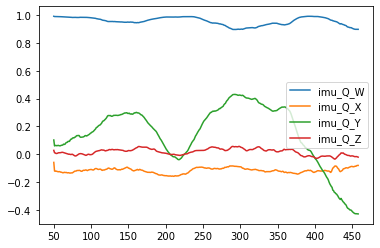

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(imu_q_ahrs["imu_Q_W"], label="imu_Q_W")
plt.plot(imu_q_ahrs["imu_Q_X"], label="imu_Q_X")
plt.plot(imu_q_ahrs["imu_Q_Y"], label="imu_Q_Y")
plt.plot(imu_q_ahrs["imu_Q_Z"], label="imu_Q_Z")
plt.legend()
plt.show()

In [20]:
frames_df = pd.concat([frames_df, imu_q_ahrs], axis = 1)

In [21]:
final_write_file = frames_df.iloc[image_frame_step:,:]
final_write_file = final_write_file[["ImageFile", "timestep", 
                               "POS_X", "POS_Y", "POS_Z", "Q_W", "Q_X", "Q_Y", "Q_Z",
                               "imu_POS_X", "imu_POS_Y", "imu_POS_Z", "imu_Q_W", "imu_Q_X","imu_Q_Y","imu_Q_Z"
                              ]]

In [22]:
final_write_file.head()

,ImageFile,timestep,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,imu_POS_X,imu_POS_Y,imu_POS_Z,imu_Q_W,imu_Q_X,imu_Q_Y,imu_Q_Z
50,frame_50.jpg,0.033330,0.125499,0.165349,-0.073962,0.990933,-0.121041,0.056528,0.014307,0.108011,0.175225,-0.067974,0.992667,-0.059644,0.101625,0.026976
51,frame_51.jpg,0.033330,0.129612,0.180918,-0.078733,0.990552,-0.123823,0.057615,0.012468,0.128038,0.181437,-0.078657,0.990768,-0.121635,0.059050,0.009868
52,frame_52.jpg,0.033329,0.133516,0.196703,-0.082764,0.990410,-0.124039,0.059980,0.010191,0.131936,0.197207,-0.082651,0.990387,-0.123398,0.061997,0.007923
53,frame_53.jpg,0.033330,0.137723,0.212410,-0.082973,0.990325,-0.124013,0.061834,0.007387,0.136101,0.212889,-0.082888,0.990551,-0.122077,0.062311,0.004785
54,frame_54.jpg,0.033331,0.141412,0.228523,-0.086279,0.990039,-0.126366,0.061613,0.007667,0.139765,0.228999,-0.086212,0.990498,-0.123486,0.060355,0.004715


In [ ]:
final_write_file.to_csv('D:/Imperial/FYP/captured_data/campus_v2/train/val.txt', 
                        header=True, 
                        index=None, 
                        sep=' ', 
                        mode='w')

# Rigid transform

In [ ]:
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [ ]:
# A = '0.png'
# B = '100.png'
# C = '10000.png'
# D = '17000.png'
A = 'frame0.jpg'
B = 'frame567.jpg'
C = 'frame1263.jpg'

In [ ]:
# Using ENU
a_pose = np.array([0, 0, 1])
b_pose = np.array([1.2, 2.5, 1.2])
c_pose = np.array([-0.5, 0.5, 1])
print(a_pose, b_pose, c_pose)

In [ ]:
px = np.sqrt(np.sum((a_pose - c_pose)**2))
a = camera_poses[camera_poses.ImageFile == A][['POS_X','POS_Y','POS_Z']].squeeze()
c = camera_poses[camera_poses.ImageFile == C][['POS_X','POS_Y','POS_Z']].squeeze()
unit_measure = np.sqrt(np.sum((a - c)**2))
print(f'colmap dist {unit_measure}, sim dist {px}')

In [ ]:
colmap_crs = camera_poses[camera_poses.ImageFile.isin([A, B, C])][['POS_X','POS_Y','POS_Z']].values.T
cadatastral_crs = np.vstack([a_pose, b_pose, c_pose]).T
colmap_crs = colmap_crs / unit_measure * px
# RA + t = B
trans_R, trans_t = rigid_transform_3D(colmap_crs, cadatastral_crs)
print(trans_R, trans_t)

In [ ]:
rotations = camera_poses[['Q_X', 'Q_Y','Q_Z', 'Q_W']].values
transform_rot = R.from_matrix(trans_R)
adjusted_colmap_ori = []
for rot in rotations:
    colmap_rot = R.from_quat(rot)
    trans_quat = (transform_rot * colmap_rot).as_euler('zyx', degrees=True)
    # if trans_quat[-1] < 0:
    #     trans_quat = -trans_quat
    adjusted_colmap_ori.append(trans_quat)

# Azimuth about z, roll about y, pitch about x
adjusted_colmap_ori = pd.DataFrame(adjusted_colmap_ori, columns=["azimuth","roll","pitch"])

In [ ]:
# Should observe that pitch is about consistent, azimuth constantly changing the most as we are walking clockwise and 
# pitch should be fluctuating slightly
adjusted_colmap_ori.plot()

In [ ]:
points = camera_poses[['POS_X', 'POS_Y','POS_Z']].values
adjusted_colmap_points = (np.matmul(trans_R, points.T) + trans_t).T
adjusted_colmap_points = pd.DataFrame(adjusted_colmap_points, columns=["POS_X","POS_Y","POS_Z"])

In [ ]:
plt.figure()
# plt.plot(train_data["POS_X"], train_data["POS_Z"], marker=".")
plt.plot(adjusted_colmap_points["POS_X"], adjusted_colmap_points["POS_Y"], marker=".")
plt.show()

In [ ]:
plt.figure()
ax = plt.axes(projection= '3d')
start = 0
end = -1

ax.plot3D(adjusted_colmap_points["POS_X"][start:end], adjusted_colmap_points["POS_Y"][start:end], adjusted_colmap_points["POS_Z"][start:end], label = "COLMAP Train Poses", color = 'green')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
ax.set_title("Aligned COLMAP Poses")
ax.legend()
plt.show()

In [ ]:
def cal_quat_angle_error(label, pred):
    if len(label.shape) == 1:
        label = np.expand_dims(label, axis=0)
    if len(pred.shape) == 1:
        pred = np.expand_dims(pred, axis=0)
    q1 = pred / np.linalg.norm(pred, axis=1, keepdims=True)
    q2 = label / np.linalg.norm(label, axis=1, keepdims=True)
    d = np.abs(np.sum(np.multiply(q1,q2), axis=1, keepdims=True)) # Here we have abs()

    d = np.clip(d, a_min=-1, a_max=1)
    error = 2 * np.degrees(np.arccos(d))
    return error

In [ ]:
err =[]
for i in range(len(adjusted_colmap_ori)):
    err.append(np.linalg.norm(adjusted_colmap_points[["POS_X", "POS_Y", "POS_Z"]].iloc[i,:] - train_data[["POS_X", "POS_Y", "POS_Z"]].iloc[i,:]))
print(f'Translation error {np.median(err)} (median) m, {np.mean(err)} (mean) m')

q_err =[]
for i in range(len(adjusted_colmap_ori)):
    q_err.append(cal_quat_angle_error(adjusted_colmap_ori[["Q_W", "Q_X", "Q_Y", "Q_Z"]].iloc[i,:], train_data[["Q_W", "Q_X", "Q_Y", "Q_Z"]].iloc[i,:]).item())
print(f'Orientation error {np.median(q_err)} (median) deg, {np.mean(q_err)} (mean) deg')

In [ ]:
q_err =[]
enus = []
ned2enu = R.from_quat(np.array([-math.sqrt(2)/2, -math.sqrt(2)/2, 0, 0]))
for i in range(len(camera_poses)):
    ned = R.from_quat(np.array(train_data[["Q_X", "Q_Y", "Q_Z", "Q_W"]].iloc[i,:]))
    enu = (ned.inv() * ned2enu).inv().as_quat()
    enus.append(enu)
    q_err.append(cal_quat_angle_error(camera_poses[["Q_X", "Q_Y", "Q_Z", "Q_W"]].iloc[i,:], enu).item())
print(f'Orientation error {np.median(q_err)} (median) deg, {np.mean(q_err)} (mean) deg')

In [ ]:
enus = pd.DataFrame(enus, columns=["Q_X","Q_Y","Q_Z", "Q_W"])
enus.plot()

In [ ]:
train_data_mod = train_data.copy()
train_data_mod["POS_X"] = adjusted_colmap_points["POS_X"]
train_data_mod["POS_Y"] = adjusted_colmap_points["POS_Y"]
train_data_mod["POS_Z"] = adjusted_colmap_points["POS_Z"]
train_data_mod["Q_X"] = adjusted_colmap_ori["Q_X"]
train_data_mod["Q_Y"] = adjusted_colmap_ori["Q_Y"]
train_data_mod["Q_Z"] = adjusted_colmap_ori["Q_Z"]
train_data_mod["Q_W"] = adjusted_colmap_ori["Q_W"]

In [ ]:
train_data_mod.to_csv(f'{true_gt_folder}/colmap_v2.txt', header=True, index=None, sep='\t', mode='w')

In [ ]:
train_data_mod[["Q_W", "Q_X", "Q_Y", "Q_Z"]].plot()